In [20]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
# from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

In [4]:
df = pd.read_csv('../data/newborn_train.csv')

In [5]:
df.head()

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight
0,30.8,2.0,220.0,1,65.0,35.0,29.0,6,0.0,2,10.0,N,F,3045
1,45.8,NaN,293.0,1,64.0,26.0,37.0,4,0.0,3,10.0,N,F,3061
2,NaN,1.0,NaN,1,66.0,NaN,33.0,6,0.0,3,NaN,N,F,3827
3,24.3,1.0,157.0,1,NaN,20.0,27.0,6,0.0,3,9.0,N,M,3997
4,24.1,1.0,187.0,1,65.0,42.0,29.0,8,0.0,2,12.0,N,F,3240


In [6]:
df.previous_cesarean = df.previous_cesarean.map({'N': 0, 'Y': 1})
df.newborn_gender = df.newborn_gender.map({'F': 0, 'M': 1})

In [7]:
X, X_test, y, y_test = train_test_split(df.drop(columns='newborn_weight'), df.newborn_weight, test_size=0.1)

### make sure you are on pycaret 3.0.2 (commented out because it runs too long, this just gives an idea on which models to focus)
```
clf = setup(df, target='newborn_weight', use_gpu=True, n_jobs=-1, fold=5)
compare_models(include=['lr', 'lasso', 'ridge', 'en', 'knn', 'dt', 'rf', 'ada', 'xgboost', 'dummy'])
                             Model       MAE          MSE      RMSE      R2  \
xgboost  Extreme Gradient Boosting  403.0712  293076.3848  541.3649  0.1598
rf         Random Forest Regressor  413.8129  304457.5004  551.7763  0.1272
lr               Linear Regression  413.9056  316197.6242  562.3139  0.0936
ridge             Ridge Regression  413.9056  316197.6230  562.3139  0.0936
lasso             Lasso Regression  413.8988  316215.5475  562.3299  0.0935
en                     Elastic Net  416.0456  318830.7009  564.6503  0.0860
ada             AdaBoost Regressor  431.3314  324992.0151  570.0752  0.0684
dummy              Dummy Regressor  436.0663  348838.5427  590.6250 -0.0000
knn          K Neighbors Regressor  450.9472  357651.2192  598.0390 -0.0253
dt         Decision Tree Regressor  597.5788  624108.1437  790.0034 -0.7891

          RMSLE    MAPE  TT (Sec)
xgboost  0.2123  0.1553     0.832
rf       0.2134  0.1570    47.774
lr       0.2220  0.1631     0.728
ridge    0.2220  0.1631     0.314
lasso    0.2220  0.1631     0.970
en       0.2227  0.1639     0.940
ada      0.2183  0.1611    30.024
dummy    0.2308  0.1722     0.264
knn      0.2283  0.1717    13.842
dt       0.3085  0.2144    10.266
```
Additionaly, compare_models return the best model (XGB in this case)
```
>>> best.feature_importances_
array([0.00643929, 0.05229881, 0.12960394, 0.15356159, 0.03544339,
       0.07295632, 0.00736365, 0.02345541, 0.05684187, 0.08091706,
       0.1431257 , 0.02327984, 0.21471319], dtype=float32)
>>> best.feature_names_in_
array(['mother_body_mass_index', 'mother_marital_status',
       'mother_delivery_weight', 'mother_race', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender'],
      dtype='<U27')
```
All of those models were run on default hyperparameters.

In [8]:
regressor = Lasso(alpha=1000, max_iter=1500, tol=0.0001)
# fill nas with median - we just want to check feature importances
regressor.fit(X.fillna(X.median()), y)

Lasso(alpha=1000, max_iter=1500)

In [22]:
r = permutation_importance(regressor, X, y,
                            n_repeats=30,
                            random_state=0)
for i in r.importances_mean.argsort()[::-1]:
 if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
     print(f"{X.columns[i]:<8}"
           f"{r.importances_mean[i]:.3f}"
           f" +/- {r.importances_std[i]:.3f}")

ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Text(0, 0.5, 'Feature')

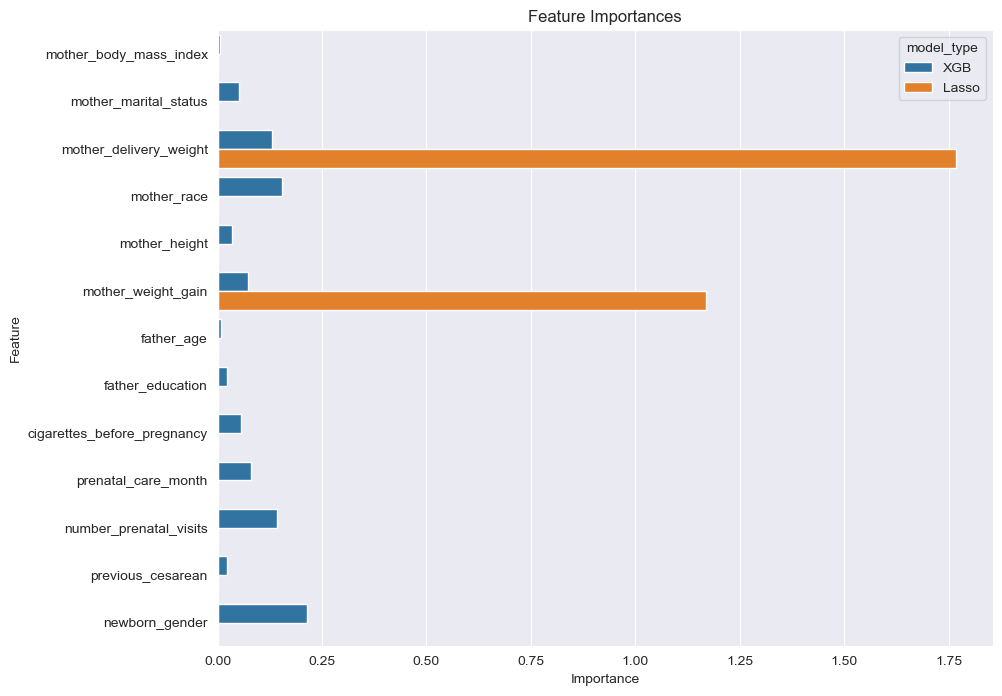

In [16]:
cols = ['mother_body_mass_index', 'mother_marital_status',
       'mother_delivery_weight', 'mother_race', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender']

xgb_importances = [0.00643929, 0.05229881, 0.12960394, 0.15356159, 0.03544339,
       0.07295632, 0.00736365, 0.02345541, 0.05684187, 0.08091706,
       0.1431257 , 0.02327984, 0.21471319]

lasso_importances = regressor.coef_

df_xgb = pd.DataFrame({
    'feature': cols,
    'importance': xgb_importances,
    'model_type': 'XGB'
})

# Create a DataFrame for Lasso data
df_lasso = pd.DataFrame({
    'feature': cols,  # assuming features are the same
    'importance': lasso_importances,
    'model_type': 'Lasso'
})

# Concatenate the two DataFrames
df = pd.concat([df_xgb, df_lasso])

# Plot the data
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', hue='model_type', data=df, orient='h')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

For Lasso, pretty much only mother_delivery_weight and mother_weight_gain were taken into account
When it comes to xgb, most important features were: newborn_gender, number_prenatal_visits, mother_race, mother_delivery_weight, prenatal_care_month.
We can pretty much get rid of mother_body_mass_index, father_age, father_education and previous_cesarean based on those models.

In [8]:
mape_dct = {}
mae_dct = {}
mse_dct = {}
rmse_dct = {}
for mdl in model_lst:
    mape_dct[str(mdl)] = []
    mae_dct[str(mdl)] = []
    mse_dct[str(mdl)] = []
    rmse_dct[str(mdl)] = []

In [ ]:
rkf = RepeatedKFold(random_state=420602)
i = 0
for train_index, test_index in rkf.split(X, y):
    print(f'split {i}')
    i += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # imputation goes here
    scaler = RobustScaler()
    imputer = IterativeImputer()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    imputer.fit(X_train_scaled)
    X_train_imputed = imputer.transform(X_train_scaled)
    X_test_scaled = scaler.transform(X_test)
    X_test_imputed = imputer.transform(X_test_scaled)
    # models
    for model_base in model_lst:
        model = model_base(verbose=1)
        model.fit(X_train_imputed, y_train)
        pred = model.predict(X_test_imputed)
        mape_dct[str(model_base)].append(mean_absolute_percentage_error(y_test, pred))
        mae_dct[str(model_base)].append(mean_absolute_error(y_test, pred))
        mse_dct[str(model_base)].append(mean_squared_error(y_test, pred))
        rmse_dct[str(model_base)].append(mean_squared_error(y_test, pred) ** 0.5)
        print(f'finished model {str(model)} for this split')

split 0
